# Well-log

In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import numpy as np
import pickle
from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tueplots import bundles

from bocpd import bocpd
from hazard import ConstantHazard
from models import DSMGaussian
from omega_estimator import OmegaEstimatorGaussian
from utils.find_cp import find_cp

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Import data

In [2]:
DATA_PATH = os.path.join(SCRIPT_DIR,'data/well-log')
RESULT_PATH = os.path.join(SCRIPT_DIR,'notebooks/results/well-log')
FILE_PATH = os.path.join(DATA_PATH,'well.txt')

In [3]:
data = np.loadtxt(FILE_PATH)
T=len(data)
data = data.reshape([T,1])

In [4]:
data_scaled = preprocessing.StandardScaler().fit_transform(data)

## Define functions needed for the method: $m$, $\nabla m$ , $\nabla r$, $\nabla b$ , $\nabla^2 r$

In [5]:
def m(x):
    return np.asarray([(1+x**2)**(-1/2)])

def grad_m(x):
    return np.asarray([[-x/((1+x**2)**(3/2))]])

def grad_r(x):
    return np.asarray([[1,-x]],dtype='float')

def grad_b(x):
    return np.asarray([[0]])

def hess_r(x):
    return np.asarray([[[0,-1]]])

## Prior parameters

In [6]:
mean_mu0 = 0
var_mu0 = 0.1

mean_Sigma0 = 1
var_Sigma0 = 0.01

mu0 = np.array([[mean_mu0/var_mu0], [1/var_mu0]])

Sigma0 = np.eye(2)
Sigma0[0,0] = mean_Sigma0/var_Sigma0
Sigma0[1,1] = 1/var_Sigma0

## Initialize estimator to find $\omega$

In [7]:
estimator = OmegaEstimatorGaussian(data_scaled[100:300], m ,grad_m, grad_r, hess_r, grad_b, mu0, Sigma0)

In [8]:
omegas, costs = estimator.omega(0.01, lr = 1e-11, niter = 15000, prior_parameters = [1, 1, 15, 20])

In [9]:
omega = omegas[-1]
print(omega)

0.0004209921171423048


## Initialize model and CP prior

In [10]:
model = DSMGaussian(data_scaled, m ,grad_m, grad_r, hess_r, grad_b, omega, mu0, Sigma0, b = 20)

In [11]:
hazard = ConstantHazard(100)

# Run BOCD algorithm

In [12]:
%%time
np.random.seed(100)
R_DSM  = bocpd(data_scaled, hazard, model, K=50, verbose=True)

Processing observation #100
Processing observation #200
Processing observation #300
Processing observation #400
Processing observation #500
Processing observation #600
Processing observation #700
Processing observation #800
Processing observation #900
Processing observation #1000
Processing observation #1100
Processing observation #1200
Processing observation #1300
Processing observation #1400
Processing observation #1500
Processing observation #1600
Processing observation #1700
Processing observation #1800
Processing observation #1900
Processing observation #2000
Processing observation #2100
Processing observation #2200
Processing observation #2300
Processing observation #2400
Processing observation #2500
Processing observation #2600
Processing observation #2700
Processing observation #2800
Processing observation #2900
Processing observation #3000
Processing observation #3100
Processing observation #3200
Processing observation #3300
Processing observation #3400
Processing observation 

## Plot

In [13]:
# Get beta-BOCD results from original implementation

with open(os.path.join(DATA_PATH,'beta.pickle'), 'rb') as handle:
    result_beta = pickle.load(handle)
    
R_beta = np.zeros((T,T))
R_beta[0,0] = 1
for i in range(T-1):
    R_beta[i+1,result_beta[14][i]] = np.exp(result_beta[12][i])
cps_beta = np.asarray(result_beta[6][-2])[:,0]

print('Time Beta-BOCD: {} minutes'.format(np.round(result_beta[1]/60,2)))

Time Beta-BOCD: 69.99 minutes


In [15]:
with open(os.path.join(DATA_PATH,'standard.pickle'), 'rb') as handle:
    result_standard = pickle.load(handle)
R_standard = np.zeros((T,T))
R_standard[0,0] = 1
for i in range(T-1):
    R_standard[i+1,result_standard[14][i]] = np.exp(result_standard[12][i])
cps_standard = np.asarray(result_standard[6][-2])[:,0]

In [17]:
cps_DSM = find_cp(R_DSM)

/tmp/ipykernel_65985/4078747614.py:43: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0)


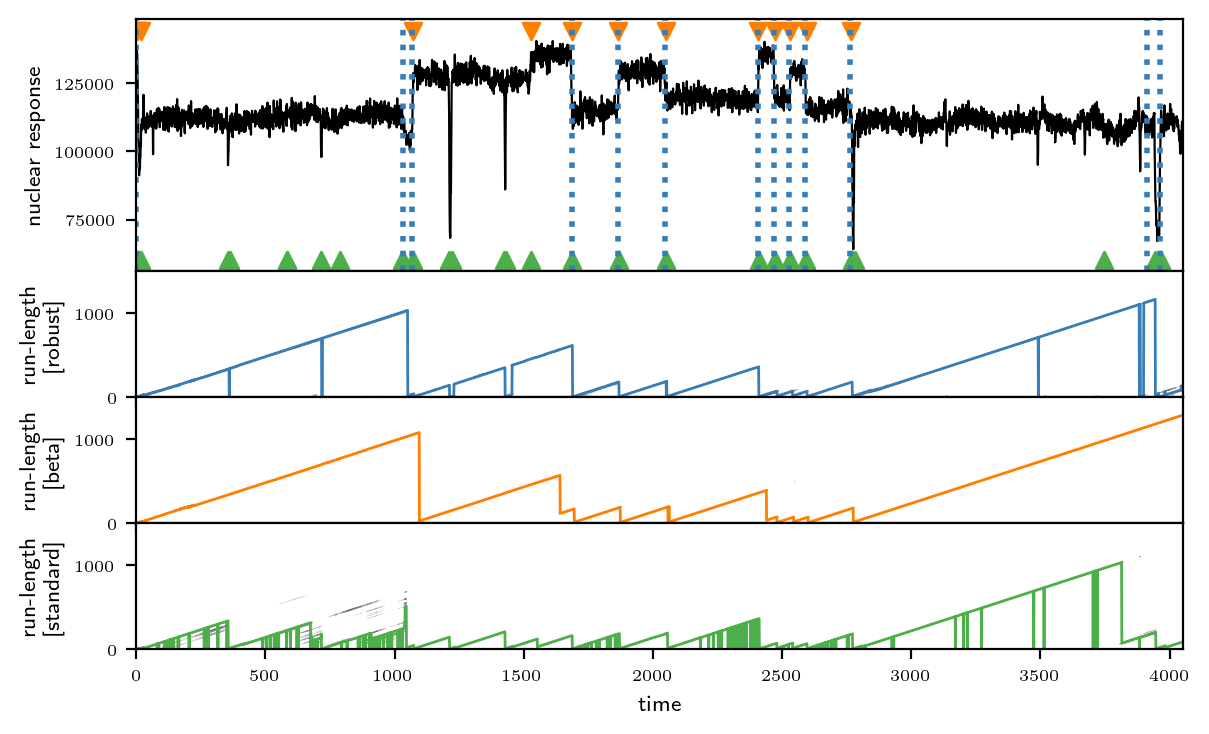

In [18]:
FILE_NAME = 'Well.pdf'
with plt.rc_context(bundles.icml2022(column='full', ncols=2, nrows=2)):

    fig, ax = plt.subplots(4, 1, sharex = True, gridspec_kw={'height_ratios': [2,1,1,1]}, dpi = 200)
    
    ax[0].set_xlim([0,T])
    ax[0].plot(data[:,0],c='black',lw=0.8)
    y_lims = ax[0].get_ylim()

    ax[1].set_xlim([0,T])
    ax[1].set_ylim([0,1500])
    ax[1].imshow(np.rot90(R_DSM), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[1].plot(np.argmax(R_DSM,axis=1), c=CB_color_cycle[0], lw=1)
    
    ax[2].set_xlim([0,T])
    ax[2].set_ylim([0,1500])
    ax[2].imshow(np.rot90(R_beta), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[2].plot(np.argmax(R_beta,axis=1), c=CB_color_cycle[1], lw=1)
    
    ax[3].set_xlim([0,T])
    ax[3].set_ylim([0,1500])
    ax[3].imshow(np.rot90(R_standard), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[3].plot(np.argmax(R_standard,axis=1), c=CB_color_cycle[2], lw=1)
    
    for cp in cps_DSM:
        ax[0].axvline(cp, c=CB_color_cycle[0], lw=2, ls='dotted')
        
    for cp in cps_beta:
        ax[0].scatter(cp, y_lims[1], marker="v", c=CB_color_cycle[1],alpha=1, lw=1)
        
    for cp in cps_standard:
        ax[0].scatter(cp, y_lims[0], marker="^", c=CB_color_cycle[2],alpha=1, lw=1)
    
    ax[0].set_ylabel('nuclear response')
    ax[1].set_ylabel('run-length\n[robust]')
    ax[2].set_ylabel('run-length\n[beta]')
    ax[3].set_ylabel('run-length\n[standard]')
    ax[3].set_xlabel('time')
        
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")

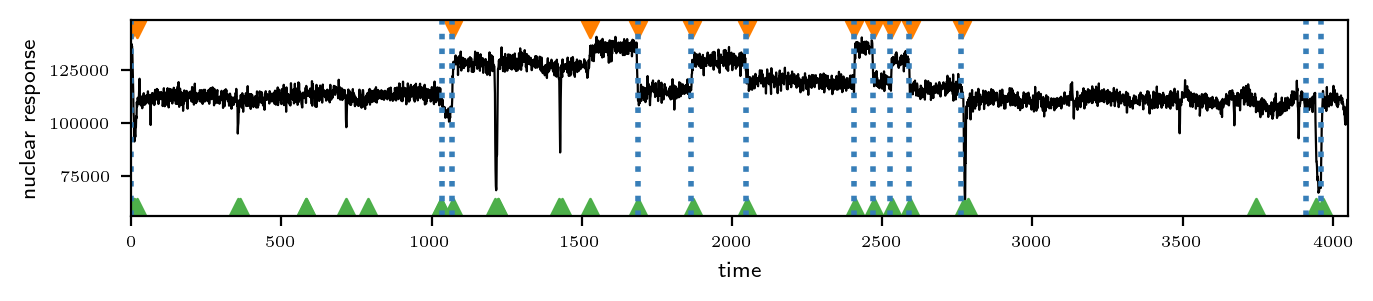

In [19]:
FILE_NAME = 'Well_no_RL.pdf'
with plt.rc_context(bundles.icml2022(column='full', ncols=3)):

    fig, ax = plt.subplots(sharex = True, dpi = 200)
    
    ax.set_xlim([0,T])
    ax.plot(data[:,0],c='black',lw=0.8)
    y_lims = ax.get_ylim()
    
    for cp in cps_DSM:
        ax.axvline(cp, c=CB_color_cycle[0], lw=2, ls='dotted')
        
    for cp in cps_beta:
        ax.scatter(cp, y_lims[1], marker="v", c=CB_color_cycle[1],alpha=1, lw=1)
        
    for cp in cps_standard:
        ax.scatter(cp, y_lims[0], marker="^", c=CB_color_cycle[2],alpha=1, lw=1)
        
    ax.set_ylabel('nuclear response')
    ax.set_xlabel('time')
        
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")